In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [3]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


In [4]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 30828
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


In [5]:
filenames = filenames[:28000]

train_files = filenames[:19600]
val_files = filenames[19600: 19600 + 5600]
test_files = filenames[-2800:]

print('Размер обучающего набора', len(train_files))
print('Размер проверочного набора', len(val_files))
print('Размер тестового набора', len(test_files))

Размер обучающего набора 19600
Размер проверочного набора 5600
Размер тестового набора 2800


In [6]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11506, 1])

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def without_zero_len(waveform, label):
    if len(waveform)!=0:  
        return True
    return False

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
count = 0
for a,_ in waveform_ds:
    count+=1
    if a.shape[0]==0:
        print(count, filenames[count])
waveform_ds = waveform_ds.filter(without_zero_len) # Удаляем сигналы нулевой длины

1171 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en045a_5.wav', shape=(), dtype=string)
2199 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en022b_76.wav', shape=(), dtype=string)
4355 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en049a_84.wav', shape=(), dtype=string)
4425 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\E\\kr021b_42.wav', shape=(), dtype=string)
8201 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\kr002b_204.wav', shape=(), dtype=string)
9690 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\kr038b_134.wav', shape=(), dtype=string)
12707 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D\\kr019a_8.wav', shape=(), dtype=string)
14965 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en012b_80.wav', shape=(), dtype=string)
17485 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\C#\\kr005b_65.wav', shape=(), dtype=string)
19349 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en031a_54.wav', shape=(), dtype=string)


In [9]:
# Загружаем триангулярные фильтры
with open('filters_1.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(5513, 83)


In [10]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    NFFT = 11025
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S, fft_length=NFFT, pad_end=True)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.tensordot(spectrogram, fbank, axes = [[1], [0]])

    return spectrogram

In [11]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram((waveform,512))


print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: D#
Waveform shape: (11506,)
Spectrogram shape: (23, 83)
Audio playback


In [12]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [13]:
step = list(map(int,[8192/32, 8192/16, 8192/8, 8192/4, 8192/2, 8192]))
num_frame = [5,10,15,20,25,30,35,40,45,50]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 10
Количество баз данных 60


In [14]:
params_s_f

[(256, 5),
 (256, 10),
 (256, 15),
 (256, 20),
 (256, 25),
 (256, 30),
 (256, 35),
 (256, 40),
 (256, 45),
 (256, 50),
 (512, 5),
 (512, 10),
 (512, 15),
 (512, 20),
 (512, 25),
 (512, 30),
 (512, 35),
 (512, 40),
 (512, 45),
 (512, 50),
 (1024, 5),
 (1024, 10),
 (1024, 15),
 (1024, 20),
 (1024, 25),
 (1024, 30),
 (1024, 35),
 (1024, 40),
 (1024, 45),
 (1024, 50),
 (2048, 5),
 (2048, 10),
 (2048, 15),
 (2048, 20),
 (2048, 25),
 (2048, 30),
 (2048, 35),
 (2048, 40),
 (2048, 45),
 (2048, 50),
 (4096, 5),
 (4096, 10),
 (4096, 15),
 (4096, 20),
 (4096, 25),
 (4096, 30),
 (4096, 35),
 (4096, 40),
 (4096, 45),
 (4096, 50),
 (8192, 5),
 (8192, 10),
 (8192, 15),
 (8192, 20),
 (8192, 25),
 (8192, 30),
 (8192, 35),
 (8192, 40),
 (8192, 45),
 (8192, 50)]

In [15]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.filter(without_zero_len) 
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [16]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
import time
EPOCHS = 100
models = []
histories = []

In [18]:
start_time0 = time.time()
tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    train_ds = []
    val_ds = []
    test_ds = []
    spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k][0]), num_parallel_calls=AUTOTUNE)
    spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k][1]))
    train_ds = spectrogram_ds
    val_ds = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ds = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    
    batch_size = 64
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    for spectrogram, _ in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
        print('input_shape',input_shape)
    
    
    mymodel = create_model(input_shape)
    
    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)


---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  5
input_shape (5, 83)
--- 14.0 минут 22.430298328399658 секунд ---
88/88 [==============================] - 0s 2ms/step
Шаг: 256 , количество спектрограмм:  5 , accuracy тестовой выборки:  74.18662853056847 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  10
input_shape (10, 83)
--- 15.0 минут 1.646737813949585 секунд ---
88/88 [==============================] - 0s 2ms/step
Шаг: 256 , количество спектрограмм:  10 , accuracy тестовой выборки:  77.5831247765463 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  15
input_shape (15, 83)
--- 15.0 минут 24.915022134780884 секунд ---
88/88 [==============================] - 0s 2ms/step
Шаг: 256 , количество спектрограмм:  15 , accuracy тестовой выборки:  80.44333214158026 %
------------------------------------------------

input_shape (35, 83)
--- 9.0 минут 1.9272844791412354 секунд ---
88/88 [==============================] - 0s 5ms/step
Шаг: 1024 , количество спектрограмм:  35 , accuracy тестовой выборки:  93.99356453342868 %
---------------------------------------------------------------------
Шаг: 1024 , количество спектрограмм:  40
input_shape (40, 83)
--- 9.0 минут 5.360835313796997 секунд ---
88/88 [==============================] - 0s 5ms/step
Шаг: 1024 , количество спектрограмм:  40 , accuracy тестовой выборки:  93.95781194136575 %
---------------------------------------------------------------------
Шаг: 1024 , количество спектрограмм:  45
input_shape (45, 83)
--- 11.0 минут 8.73885178565979 секунд ---
88/88 [==============================] - 1s 7ms/step
Шаг: 1024 , количество спектрограмм:  45 , accuracy тестовой выборки:  94.0293171254916 %
---------------------------------------------------------------------
Шаг: 1024 , количество спектрограмм:  50
input_shape (50, 83)
--- 9.0 минут 56.69849

input_shape (15, 83)
--- 6.0 минут 39.2116494178772 секунд ---
88/88 [==============================] - 1s 8ms/step
Шаг: 8192 , количество спектрограмм:  15 , accuracy тестовой выборки:  93.67179120486236 %
---------------------------------------------------------------------
Шаг: 8192 , количество спектрограмм:  20
input_shape (20, 83)
--- 7.0 минут 15.151811122894287 секунд ---
88/88 [==============================] - 1s 9ms/step
Шаг: 8192 , количество спектрограмм:  20 , accuracy тестовой выборки:  92.92098677154094 %
---------------------------------------------------------------------
Шаг: 8192 , количество спектрограмм:  25
input_shape (25, 83)
--- 8.0 минут 10.175304174423218 секунд ---
88/88 [==============================] - 1s 9ms/step
Шаг: 8192 , количество спектрограмм:  25 , accuracy тестовой выборки:  93.17125491598141 %
---------------------------------------------------------------------
Шаг: 8192 , количество спектрограмм:  30
input_shape (30, 83)
--- 8.0 минут 10.9804

In [19]:
for k in range(len(models)):
    print(k, params_s_f[k][0])
    models[k].summary()

0 256
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 83)]           0         
                                                                 
 flatten (Flatten)           (None, 415)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               212992    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 744,460
Trainable params: 744,460
Non-tra

 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 2,019,340
Trainable params: 2,019,340
Non-trainable params: 0
_________________________________________________________________
7 256
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 40, 83)]          0         
                                                                 
 flatten_7 (Flatten)         (None, 3320)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1700352   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)   

                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 1,381,900
Trainable params: 1,381,900
Non-trainable params: 0
_________________________________________________________________
14 512
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25, 83)]          0         
                                                                 
 flatten_14 (Flatten)        (None, 2075)              0         
                                         

 inputs (InputLayer)         [(None, 5, 83)]           0         
                                                                 
 flatten_20 (Flatten)        (None, 415)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               212992    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 744,460
Trainable params: 744,460
Non-trainable params: 0
_________________________________________________________________
21 1024
Model: "model_21"
____________________________________________

Total params: 2,019,340
Trainable params: 2,019,340
Non-trainable params: 0
_________________________________________________________________
27 1024
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 40, 83)]          0         
                                                                 
 flatten_27 (Flatten)        (None, 3320)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1700352   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12) 

 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 1,381,900
Trainable params: 1,381,900
Non-trainable params: 0
_________________________________________________________________
34 2048
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25, 83)]          0         
                                                                 
 flatten_34 (Flatten)        (None, 2075)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1062912   
                                                                 
 relu_2 (Dense)              (None, 512)

                                                                 
 relu_1 (Dense)              (None, 512)               212992    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 744,460
Trainable params: 744,460
Non-trainable params: 0
_________________________________________________________________
41 4096
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10, 83)]          0         
                                            

 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 40, 83)]          0         
                                                                 
 flatten_47 (Flatten)        (None, 3320)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1700352   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 2,231,820
Trainable params: 2,231,820
Non-trainable params: 0
_________________________________________________________________


                                                                 
Total params: 1,381,900
Trainable params: 1,381,900
Non-trainable params: 0
_________________________________________________________________
54 8192
Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25, 83)]          0         
                                                                 
 flatten_54 (Flatten)        (None, 2075)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1062912   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                        

In [20]:
np.array(tests_acc)

array([74.18662853, 77.58312478, 80.44333214, 85.1269217 , 87.8441187 ,
       89.48873793, 90.81158384, 92.70647122, 92.74222381, 92.95673936,
       78.22667143, 85.66321058, 90.23954237, 92.24168752, 93.02824455,
       93.81480157, 93.52878084, 93.92205935, 93.45727565, 93.49302824,
       85.5917054 , 92.84948159, 93.17125492, 93.77904898, 94.67286378,
       94.1365749 , 93.99356453, 93.95781194, 94.02931713, 92.63496604,
       93.27851269, 94.6013586 , 93.95781194, 94.10082231, 94.06506972,
       93.74329639, 93.92205935, 94.38684305, 94.78012156, 94.35109045,
       94.38684305, 93.81480157, 94.1365749 , 93.45727565, 94.20808009,
       93.13550232, 93.74329639, 93.7075438 , 93.42152306, 94.20808009,
       94.1365749 , 93.38577047, 93.6717912 , 92.92098677, 93.17125492,
       93.2427601 , 91.91991419, 92.70647122, 92.24168752, 93.13550232])

Text(51.0, 0.5, 'Шаг')

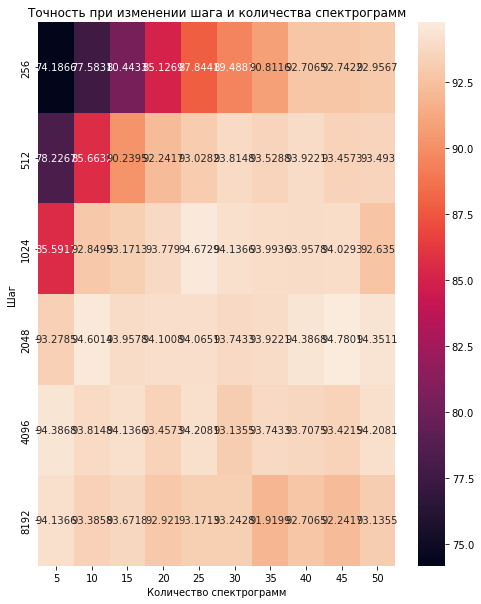

In [21]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

In [22]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (256, 5) 74.18662853056847
1 (256, 10) 77.5831247765463
2 (256, 15) 80.44333214158026
3 (256, 20) 85.12692170182338
4 (256, 25) 87.84411869860564
5 (256, 30) 89.48873793350019
6 (256, 35) 90.81158383982839
7 (256, 40) 92.70647121916339
8 (256, 45) 92.74222381122631
9 (256, 50) 92.95673936360386
10 (512, 5) 78.22667143367894
11 (512, 10) 85.66321058276725
12 (512, 15) 90.2395423668216
13 (512, 20) 92.24168752234537
14 (512, 25) 93.02824454772971
15 (512, 30) 93.81480157311405
16 (512, 35) 93.52878083661066
17 (512, 40) 93.92205934930283
18 (512, 45) 93.45727565248481
19 (512, 50) 93.49302824454773
20 (1024, 5) 85.59170539864141
21 (1024, 10) 92.84948158741508
22 (1024, 15) 93.17125491598141
23 (1024, 20) 93.77904898105113
24 (1024, 25) 94.67286378262423
25 (1024, 30) 94.13657490168038
26 (1024, 35) 93.99356453342868
27 (1024, 40) 93.95781194136575
28 (1024, 45) 94.0293171254916
29 (1024, 50) 92.63496603503754
30 (2048, 5) 93.27851269217018
31 (2048, 10) 94.6013585984984
32 (2048, 15) 

In [23]:
k_max = np.argmax(np.array(tests_acc))
k_max

38

In [24]:
params_s_f[k_max][0],params_s_f[k_max][1]

(2048, 45)

In [25]:
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [26]:
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [27]:
history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

88/88 [==============================] - 1s 12ms/step


94.78012155881301

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

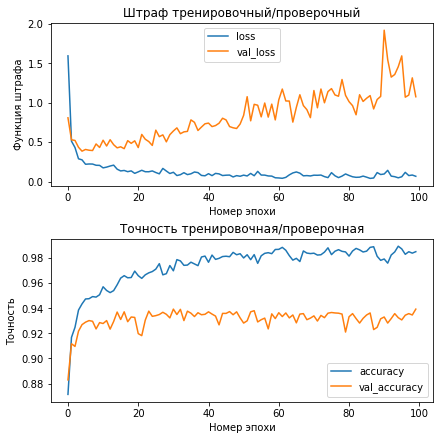

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

In [29]:
y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels

88/88 [==============================] - 1s 12ms/step


In [30]:
y_true.shape

(2797,)

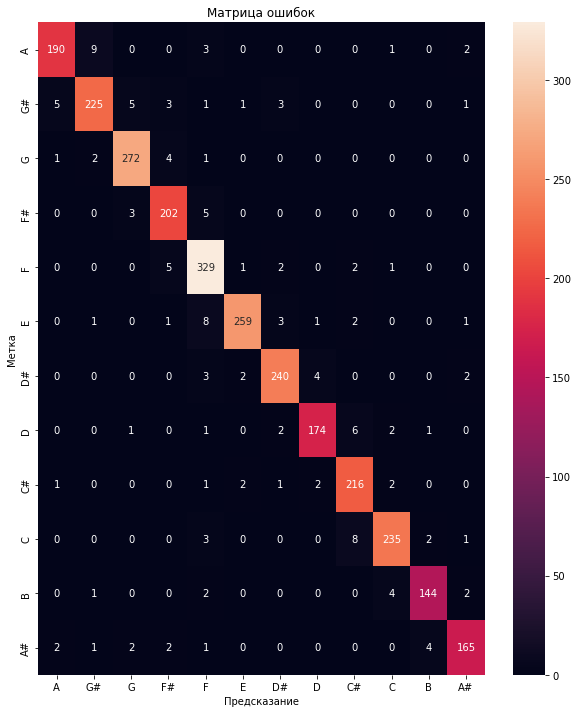

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [32]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)
files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
output_ds = output_ds.filter(without_zero_len) 
output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
sample_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


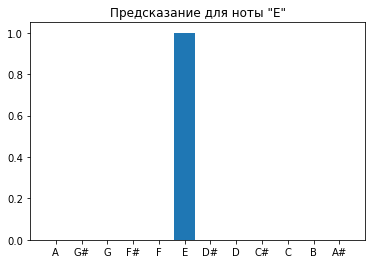

In [33]:
for spectrogram, label in sample_ds.batch(1):
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()

______________________________

In [34]:
tests_acc = [test_acc]
EPOCHS = [100,10,50,75,300,500]
models = [model_]
histories = [history_]

train_ds = []
val_ds = []
test_ds = []
spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_files,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('input_shape',input_shape)



input_shape (45, 83)


In [35]:
for k in range(1,len(EPOCHS)):
    print('---------------------------------------------------------------------')

    mymodel = create_model(input_shape)

    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS[k], verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")

    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Эпохи: ',EPOCHS[k], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)

---------------------------------------------------------------------
--- 2.0 минут 40.05834460258484 секунд ---
88/88 [==============================] - 1s 12ms/step
Эпохи:  10 , accuracy тестовой выборки:  92.42045048265999 %
---------------------------------------------------------------------
--- 5.0 минут 21.693210124969482 секунд ---
88/88 [==============================] - 1s 12ms/step
Эпохи:  50 , accuracy тестовой выборки:  94.63711119056131 %
---------------------------------------------------------------------
--- 7.0 минут 56.11911225318909 секунд ---
88/88 [==============================] - 1s 11ms/step
Эпохи:  75 , accuracy тестовой выборки:  94.27958526993207 %
---------------------------------------------------------------------
--- 44.0 минут 48.81255269050598 секунд ---
88/88 [==============================] - 1s 15ms/step
Эпохи:  300 , accuracy тестовой выборки:  92.38469789059707 %
---------------------------------------------------------------------
--- 13.0 минут 

In [36]:
k_max_new = np.argmax(np.array(tests_acc))
k_max_new

0

In [37]:
history_1 = histories[k_max_new]
model_1 = models[k_max_new]
metrics = history_1.history

y_pred = np.argmax(model_1.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

88/88 [==============================] - 1s 15ms/step


94.78012155881301

In [38]:
model_1.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 45, 83)]          0         
                                                                 
 flatten_38 (Flatten)        (None, 3735)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               1912832   
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 2,444,300
Trainable params: 2,444,300
Non-tr

In [47]:
model_.save(r"D:\magistracy\diplom\model\model_4.h5")

__________________

In [44]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[1]
    width = spectrogram.shape[0]
    #X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    X = np.array(range(width))
    Y = np.array(range(height))
    ax.pcolormesh(X, Y, spectrogram.T)

C:\Users\belas\AppData\Local\Temp/ipykernel_13400/3168724974.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


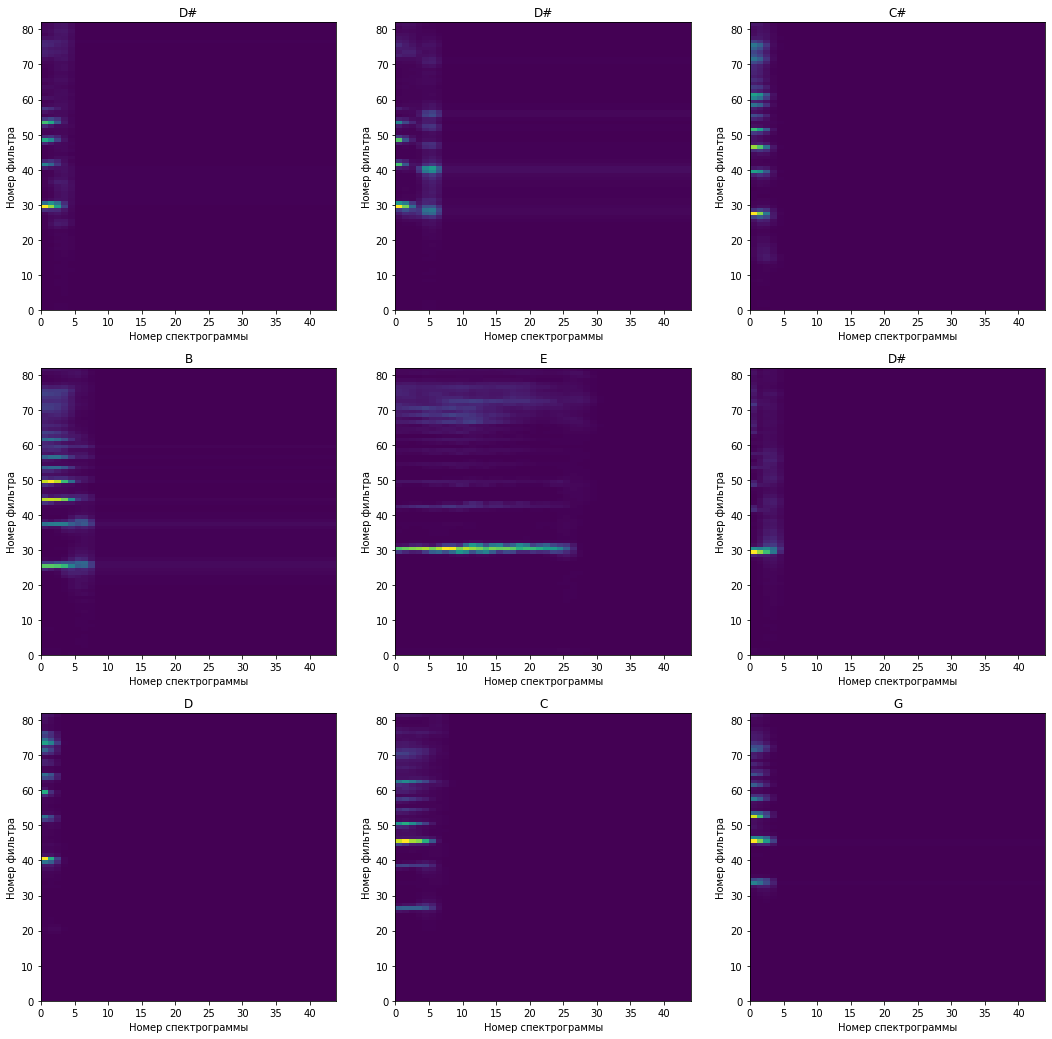

In [45]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    
    plot_spectrogram(np.squeeze(spectrogram.numpy()), axes[r][c])
    axes[r][c].set_title(notes[label_id.numpy()])
    axes[r][c].set_xlabel('Номер спектрограммы')
    axes[r][c].set_ylabel('Номер фильтра')


plt.show()